In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
# This data augmentation lead to serious overfitting issue

#datagen=ImageDataGenerator(
#rescale = 1./255,
#featurewise_center=False,  # set input mean to 0 over the dataset
#samplewise_center=False,  # set each sample mean to 0
#featurewise_std_normalization=False,  # divide inputs by std of the dataset
#samplewise_std_normalization=False,  # divide each input by its std
#zca_whitening=False,  # apply ZCA whitening
#rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#zoom_range = 0.1, # Randomly zoom image 
#width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
#horizontal_flip=False,  # randomly flip images
#vertical_flip=False,  # randomly flip images
#validation_split=0.1)

In [0]:
from keras.applications.resnet50 import preprocess_input

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                 #  rescale = 1./255, DO NOT USE THIS ONE WITH PREPROCESS_INPUT
                                   horizontal_flip=True,
                   #                width_shift_range = 0.4,
                   #                height_shift_range = 0.4,
                   #                zoom_range=0.3,
                   #                rotation_range=20,
                                   validation_split=0.2
                                   )

In [0]:
image_size = 224
train_batch_size = 32
valid_batch_size = 32

In [7]:
train_generator=datagen.flow_from_directory(
'/content/drive/My Drive/Datasets/flowers/',
subset="training",
batch_size=train_batch_size,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(image_size, image_size))

valid_generator=datagen.flow_from_directory(
'/content/drive/My Drive/Datasets/flowers/',
subset="validation",
batch_size=valid_batch_size,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(image_size, image_size))

Found 3478 images belonging to 5 classes.
Found 865 images belonging to 5 classes.


In [8]:
from collections import Counter

num_classes = len(train_generator.class_indices)
print('Number of classes: ', num_classes)
print('\n')
print('No. of images in Train: ', train_generator.n)
print('Train distribution: ', sorted(Counter(train_generator.classes).items()))
print('\n')
print('No. of images in Validation: ', valid_generator.n)
print('Validation distribution: ',sorted(Counter(valid_generator.classes).items()))

Number of classes:  5


No. of images in Train:  3478
Train distribution:  [(0, 616), (1, 842), (2, 644), (3, 588), (4, 788)]


No. of images in Validation:  865
Validation distribution:  [(0, 153), (1, 210), (2, 160), (3, 146), (4, 196)]


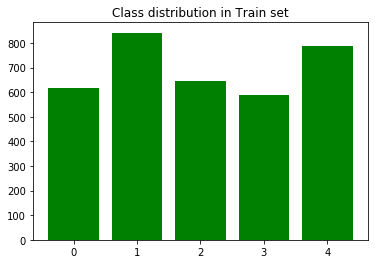

In [9]:
plt.bar(list(Counter(train_generator.classes).keys()), Counter(train_generator.classes).values(), color='g')
plt.title('Class distribution in Train set')
plt.show()

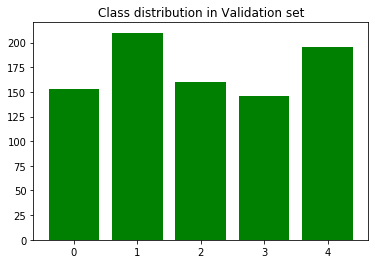

In [10]:
plt.bar(list(Counter(valid_generator.classes).keys()), Counter(valid_generator.classes).values(), color='g')
plt.title('Class distribution in Validation set')
plt.show()

**Build a Model**

In [11]:
base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (image_size,image_size,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

#x = Dense(1024,activation = 'relu')(x)
#x = BatchNormalization()(x)

predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

#for layer in base_model.layers:
#    layer.trainable = False













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



**Attention when using dropout**

Due to disabling neurons, some information about each sample is lost, and the subsequent layers attempt to construct the answers basing on incomplete representations. The training loss is higher because you've made it artificially harder for the network to give the right answers. However, during validation all of the units are available, so the network has its full computational power - and thus it might perform better than in training.

In [12]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=1E-5)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
#model = Sequential()

#model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

#model.add(BatchNormalization())
#model.add(Dense(2048, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(1024, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dense(num_classes, activation='softmax'))

#model.layers[0].trainable = False

In [0]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Use Keras with GPU**

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3691688599894373879
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17497650827200574577
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17905586396106921982
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7470045594
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13669605685172733161
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


In [16]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [17]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1



**Train Model**

In [19]:
#count = sum([len(files) for r, d, files in os.walk("/content/drive/My Drive/Datasets/flowers/")])
train_count = train_generator.n
valid_count = valid_generator.n

train_fit = model.fit_generator(generator=train_generator,
                                steps_per_epoch=int(train_count/train_batch_size) + 1,
                                validation_data=valid_generator,
                                validation_steps=int(valid_count/valid_batch_size) + 1,
                                epochs=10)

Epoch 1/10
109/109 [==============================] - 67s 613ms/step - loss: 1.1458 - acc: 0.6423 - val_loss: 0.4945 - val_acc: 0.8358
Epoch 2/10
109/109 [==============================] - 66s 609ms/step - loss: 0.8865 - acc: 0.7296 - val_loss: 0.3777 - val_acc: 0.8717
Epoch 3/10
109/109 [==============================] - 66s 609ms/step - loss: 0.6714 - acc: 0.7888 - val_loss: 0.3319 - val_acc: 0.8821
Epoch 4/10
109/109 [==============================] - 66s 608ms/step - loss: 0.5697 - acc: 0.8237 - val_loss: 0.3079 - val_acc: 0.8983
Epoch 5/10
109/109 [==============================] - 66s 608ms/step - loss: 0.4618 - acc: 0.8613 - val_loss: 0.2762 - val_acc: 0.9006
Epoch 6/10
109/109 [==============================] - 66s 608ms/step - loss: 0.3649 - acc: 0.8792 - val_loss: 0.2689 - val_acc: 0.9029
Epoch 7/10
109/109 [==============================] - 66s 609ms/step - loss: 0.3073 - acc: 0.9016 - val_loss: 0.2524 - val_acc: 0.9202
Epoch 8/10
109/109 [==============================] - 6

**Confusion Matrix and Classification Report on Validation set**

In [20]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix #, plot_confusion_matrix

# Calculate Confusion Matrix
Y_pred = model.predict_generator(valid_generator, valid_count // valid_batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(valid_generator.classes, y_pred)

# Calculate Classification_report
target_names = list(train_generator.class_indices.keys()) # this would save our ass when we have many classes
#target_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
cf = classification_report(valid_generator.classes, y_pred, target_names=target_names)

# Show results
print('Confusion Matrix')
print(cm)

print('Classification Report')
print(cf)

Confusion Matrix
[[141   7   1   1   3]
 [  3 197   0   6   4]
 [  2   0 146   1  11]
 [  0   6   3 132   5]
 [  1   3   7   6 179]]
Classification Report
              precision    recall  f1-score   support

       daisy       0.96      0.92      0.94       153
   dandelion       0.92      0.94      0.93       210
        rose       0.93      0.91      0.92       160
   sunflower       0.90      0.90      0.90       146
       tulip       0.89      0.91      0.90       196

    accuracy                           0.92       865
   macro avg       0.92      0.92      0.92       865
weighted avg       0.92      0.92      0.92       865



In [21]:
valid_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

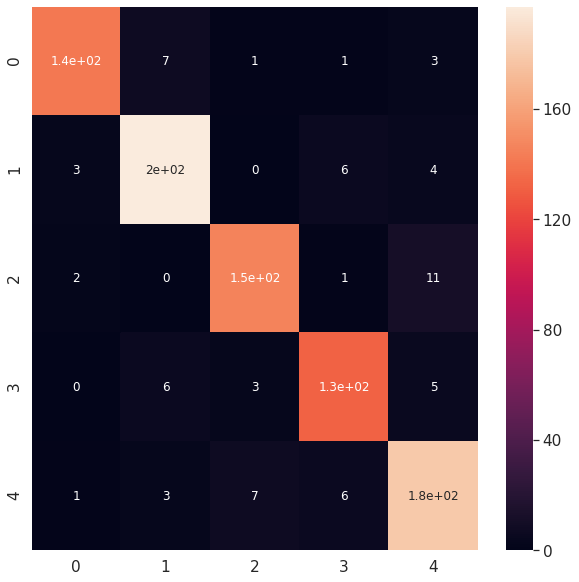

In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(num_classes), range(num_classes))

plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size

plt.show()

In [0]:
# Double check classes here
#y_pred
#valid_generator.classes

**Loss and accuracy**

In [24]:
model.evaluate_generator(generator=valid_generator,
steps=int(valid_count/train_batch_size) + 1)

[0.24493527164349346, 0.9190751445086706]

In [25]:
model.metrics_names

['loss', 'acc']

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [0]:
train_loss_unfrozen_lnr1Emin5_Aug= train_fit.history['loss']
train_acc_unfrozen_lnr1Emin5_Aug = train_fit.history['acc']

val_loss_unfrozen_lnr1Emin5_Aug= train_fit.history['val_loss']
val_acc_unfrozen_lnr1Emin5_Aug = train_fit.history['val_acc']

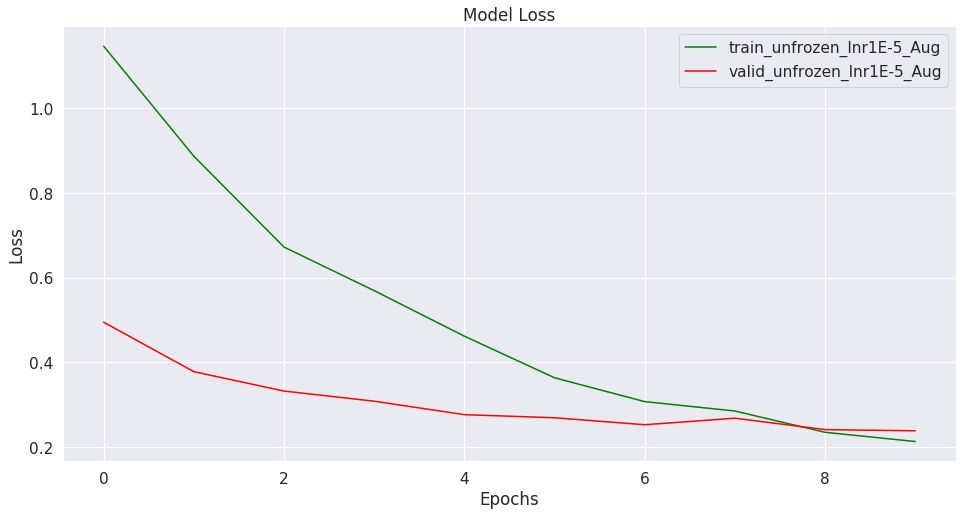

In [28]:
plt.figure(figsize=(16,8))

plt.plot(train_loss_unfrozen_lnr1Emin5_Aug, color = 'green')
plt.plot(val_loss_unfrozen_lnr1Emin5_Aug, color = 'red')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train_unfrozen_lnr1E-5_Aug','valid_unfrozen_lnr1E-5_Aug'])
plt.show()

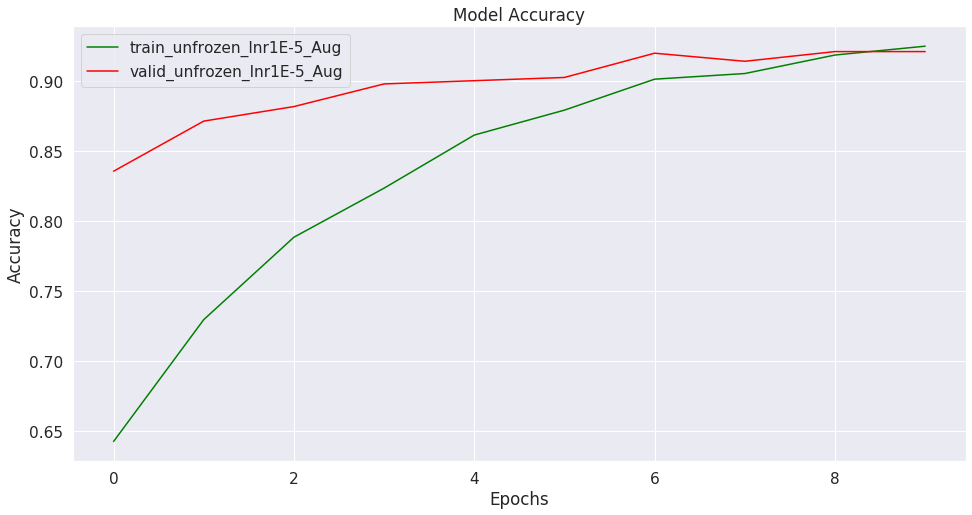

In [29]:
plt.figure(figsize=(16,8))

plt.plot(train_acc_unfrozen_lnr1Emin5_Aug, color = 'green')
plt.plot(val_acc_unfrozen_lnr1Emin5_Aug, color = 'red')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train_unfrozen_lnr1E-5_Aug','valid_unfrozen_lnr1E-5_Aug'])
plt.show()

**Visualization with some samples**

In [0]:
from IPython.display import Image, display

import os, random
img_locations = []
for d in os.listdir("/content/drive/My Drive/Datasets/flowers/"):
    directory = "/content/drive/My Drive/Datasets/flowers/" + d
    sample = [directory + '/' + s for s in random.sample(
        os.listdir(directory), int(random.random()*10))]
    img_locations += sample

In [31]:
def read_and_prep_images(img_paths, img_height=image_size, img_width=image_size):
    imgs = [load_img(img_path, target_size=(img_height, img_width)) for img_path in img_paths]
    img_array = np.array([img_to_array(img) for img in imgs])
    return preprocess_input(img_array)

random.shuffle(img_locations)
imgs = read_and_prep_images(img_locations)
predictions = model.predict_classes(imgs)
classes = dict((v,k) for k,v in train_generator.class_indices.items())

for img, prediction in zip(img_locations, predictions):
    display(Image(img))
    print(classes[prediction])

AttributeError: ignored